# Lab session 4 | Convolutional Neural Networks (CNN) with pytorch

pierre-henri.conze@imt-atlantique.fr \\
francois.rousseau@imt-atlantique.fr \\
simon.benaichouche@imt-atlantique.fr \\
aurelien.colin@imt-atlantique.fr

---



## Objective of this lab session: perform classification on MNIST using convolutional neural networks

In lab session 3, MNIST classification has been performed relying on Multi-Layer Perceptron (MLP) models. The obtained accuracy was 92% with a softmax regressor and 97% (or 98%) with a deeper MLP. This can be further improved! Let us jump from such simple models to something moderately more sophisticated, namely **Convolutional Neural Networks** (CNN).

For recall, **MNIST** is a computer vision dataset which consists of handwritten digit images with associated label. Each image in MNIST has a corresponding label - a number between 0 and 9 - representing the digit drawn in the image.

### 1- Data management

Start with these lines of code to automatically download the MNIST dataset.

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor() # convert data to torch.FloatTensor

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

/homes/a19sella/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### **Question 1.1** - Complete the following cell to create **data loaders** ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets.

In [2]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):
    num_train, num_test = len(train_data), len(test_data)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
    return train_loader, valid_loader, test_loader

In [3]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

Let us visualize some images from the training set with corresponding ground truth labels.

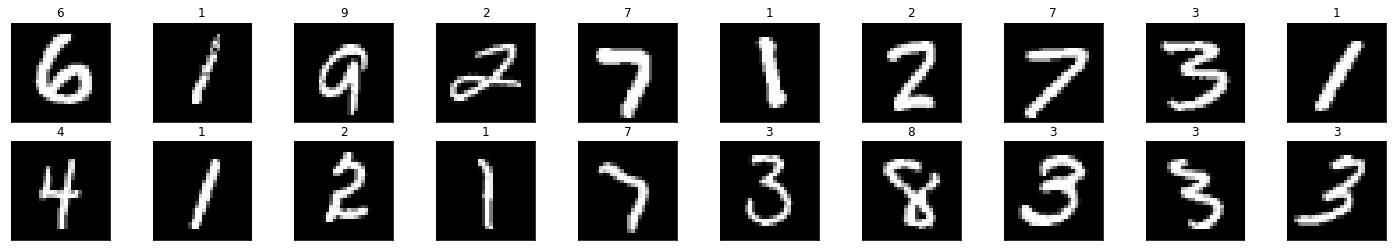

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(train_loader) 
images, labels = data_iter.next() # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

### 2- Simple CNN architecture

Let us define a simple **CNN architecture**. The network will take as inputs 28x28 images instead of 784-dimensional tensors of pixel values as for MLP models. As in lab session 3, it will produce as output a tensor of length 10 (i.e. the number of classes) that indicates the class scores for each input image. A CNN architecture is a stack of layers including:
  - convolutional layer using *nn.Conv2D* ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
  - max-pooling layer using *nn.MaxPool2D* ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
  - regular densely-connected layer using *nn.Linear* ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html))

#### **Question 2.1** - In this first network architecture (*Net1*), employ:
 - 2 consecutive convolutional layers using 32 3x3 filters with stride 1 followed by *ReLU* activation,
 - a max pooling with vertical and horizontal downscale of 2,
 - a flatten operator to flatten the input array,
 - a dense layer with 10 units.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):  

    def __init__(self):
        super(Net1,self).__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,32,3)
        self.rel1  = nn.ReLU()
        self.rel2  = nn.ReLU()
        self.pool  = nn.MaxPool2d(2,2)
        self.fc    = nn.Linear(32*32,10)
        
        
        
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.rel1(out)
        out = self.conv2(out)
        out = self.rel2(out)
        out = self.pool(out)
        out = out.view(-1,32*32) 
        out = self.fc(out)
        return out

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


**torchsummary** provides information complementary to what is provided by *print(your_model)* in PyTorch, similar to the Tensorflow *model.summary()* routine ([documentation](https://pypi.org/project/torch-summary/)). This can be helpful while debugging your network!

#### **Question 2.2** - Describe input/output sizes of each layer. Confirm your analysis by using *summary()* from *torchsummary*.

In [7]:
from torchsummary import summary

cnn_1 = Net1() # initialize the neural network
cnn_1.to(device=device)

summary(cnn_1, (1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 26, 26]          320
├─ReLU: 1-2                              [-1, 32, 26, 26]          --
├─Conv2d: 1-3                            [-1, 32, 24, 24]          9,248
├─ReLU: 1-4                              [-1, 32, 24, 24]          --
├─MaxPool2d: 1-5                         [-1, 32, 12, 12]          --
├─Linear: 1-6                            [-1, 10]                  10,250
Total params: 19,818
Trainable params: 19,818
Non-trainable params: 0
Total mult-adds (M): 5.51
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 0.08
Estimated Total Size (MB): 0.38


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 26, 26]          320
├─ReLU: 1-2                              [-1, 32, 26, 26]          --
├─Conv2d: 1-3                            [-1, 32, 24, 24]          9,248
├─ReLU: 1-4                              [-1, 32, 24, 24]          --
├─MaxPool2d: 1-5                         [-1, 32, 12, 12]          --
├─Linear: 1-6                            [-1, 10]                  10,250
Total params: 19,818
Trainable params: 19,818
Non-trainable params: 0
Total mult-adds (M): 5.51
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 0.08
Estimated Total Size (MB): 0.38

#### **Question 2.3** - Before training a model, configure the learning process by indicating the criterion (i.e the objective loss function the model will try to minimize) as well as the optimizer.

In [8]:
criterion = nn.CrossEntropyLoss() 

In [9]:
optimizer = torch.optim.SGD(cnn_1.parameters(),lr = 0.01)

### 3- Training

#### **Question 3.1** - Complete the following cell to perform the training.

In [10]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses
      
      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          optimizer.zero_grad()
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
          loss = criterion(output, label) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step()      
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
              output = model(data)
          loss = criterion(output,label)
          valid_loss += loss.item() * data.size(0)
      
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
      
  return train_losses, valid_losses      

In [11]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, cnn_1, criterion, optimizer)

ValueError: Expected input batch_size (90) to match target batch_size (20).

To study the **convergence** of the training process, we plot the evolution of the loss function for training and validation sets with respect to epochs.

In [ ]:
plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

Let us load the model corresponding to the lowest validation loss.

In [ ]:
cnn_1.load_state_dict(torch.load('model.pt', map_location=device))

### 4- Testing

#### **Question 4.1** - Complete the following cell to test the (best) model on previously unseen test data and evaluate its performance through per-class and global accuracy scores.

In [ ]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = ... # forward pass: compute predicted outputs by passing inputs to the model
      loss = criterion( ...  )
    
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1) # convert output probabilities to predicted class
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %1s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [ ]:
evaluation( ... ) 

#### **Question 4.2** - What is the overall accuracy achieved for test data? **Answer** : ... %.

### 5- Assessment

The following cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

In [ ]:
def visualization(model, test_loader):

  data_iter = iter(test_loader)
  images, labels = data_iter.next() # obtain one batch of test images
  images = images.to(device=device, dtype=torch.float32)
  labels = labels.to(device=device, dtype=torch.long)
  with torch.no_grad():
      output = model(images) # get model output
  _, preds = torch.max(output, 1) # convert output probabilities to predicted class
  images = images.cpu().numpy() # prep images for display
  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
visualization(cnn_1, test_loader)

Let us extract predicted (*preds*) and ground truth (*targets*) labels for images arising from the test set.

In [ ]:
def get_all_prediction(model, loader):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [ ]:
targets, preds_1 = get_all_prediction(cnn_1, test_loader)

#### **Question 5.1** - Visualize some wrongly predicted data.

#### **Question 5.2** - Display the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

class_names= ['0','1','2','3','4','5','6','7','8','9']

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
# compute confusion matrix
cnf_matrix = 


# plot normalized confusion matrix



plt.show()

### 6 - Robustness to noise

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean, std):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

Image transformations can be chained together using *Compose* ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)).

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.8)
])

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [ ]:
train_loader_n, valid_loader_n, test_loader_n = create_data_loaders(batch_size, valid_size, train_data, test_data)

Let us visualize some noisy images with corresponding ground truth labels.

In [ ]:
data_iter = iter(train_loader_n) 
images, labels = data_iter.next() # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

#### **Question 6.1** - Train the network on noisy data and evaluate it.

In [ ]:
train_losses_n, valid_losses_n = 

In [ ]:
cnn_1.load_state_dict(torch.load('model.pt', map_location=device))

In [ ]:
evaluation(...) 

### 7- Towards deeper CNN models


In this last part, we come back to the original dataset, i.e. without additional noise.

#### **Question 7.1** - Implement a deeper convolutional neural network by adding two convolutional layers, one max pooling layer as well as dropout.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module): 

    def __init__(self):
        super(Net2,self).__init__()
        

        
        
        
        
        
        
        
        
        
    def forward(self,x):

        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        return out

In [ ]:
cnn_2 = Net2()
cnn_2.to(device=device)

summary(...) 

In [ ]:
optimizer = 

In [ ]:
train_losses_2, valid_losses_2 = 

In [ ]:
cnn_2.load_state_dict(torch.load('model.pt', map_location=device))

#### **Question 7.2** - Quantify the gain from *Net1* to *Net2* in term of overall accuracy.

In [ ]:
evaluation(...) 

#### **Question 7.3** - What are the results for incorrect predictions arising from *Net1*?

In [ ]:
_, preds_2 = 

You may display test images and labels in the following format: predicted from *Net1* (ground-truth) | predicted from *Net2*.

In [ ]:
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({}) | {}".format(str(np.int(preds_1[index[i]])), str(np.int(targets[index[i]])), str(np.int(preds_2[index[i]]))), color=("green" if preds_2[index[i]]==targets[index[i]] else "red"))
plt.show()

### 8- Interactive demonstration

To finish this lab session, let us play with the following interactive demo: [link](http://mnist-demo.herokuapp.com). This web application demonstrates the ability of both CNN and MLP models to classify handwritten digits.

#### **Question 8.1** - Try to draw a digit which is more accurately classified by CNN than MLP. 



---

